In [82]:
# Install these packages if you haven't in the kernel 
# !pip install numpy opencv-python tensorflow keras
# !pip install tensorflow
# !pip install tensorflow-gpu
# !pip install opencv-python
# !pip install matplotlib
# !pip install numpy
# !pip install opencv-contrib-python 
# !pip install tensorflow-datasets
# !pip install datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array

In [3]:
from datasets import load_dataset

ds = load_dataset("FER-Universe/DiffusionFER")

Found cached dataset imagefolder (C:/Users/Bojana/.cache/huggingface/datasets/FER-Universe___imagefolder/FER-Universe--DiffusionFER-5e50418690f14861/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2581
    })
})

In [5]:
data = ds['train'].to_pandas()
data

,image,label
0,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",0
1,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",0
2,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",0
3,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",0
4,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",0
...,...,...
2576,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",6
2577,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",6
2578,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",6
2579,"{'bytes': None, 'path': 'C:\Users\Bojana\.cach...",6


In [6]:
data.iloc[0].image['path']

'C:\\Users\\Bojana\\.cache\\huggingface\\datasets\\downloads\\extracted\\e360db2d0f95f6b228b22417012e198ecdd834de8137740b583894ab9eccd85b\\angry\\aaaaaaaa_6.png'

In [7]:
# DOWNSAMPLING
data['label'].value_counts() # classes are not equal  - we will cut them so there won't be a biased class

label
4    698
3    681
6    364
0    356
1    176
5    162
2    144
Name: count, dtype: int64

In [8]:
min_class_size = 144 

In [9]:
def downsample(df, label_column, n_samples):
    return df.groupby(label_column).apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)

data = downsample(data, 'label', min_class_size)

print(data['label'].value_counts())

label
0    144
1    144
2    144
3    144
4    144
5    144
6    144
Name: count, dtype: int64


In [10]:
import zipfile
import os
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

image_list = []

def extract_image_from_zip(image_path):
    # Extract the zip file path and image name
    parts = image_path.split('::')
    zip_file_path = parts[1]  # Path to the zip file
    image_name_in_zip = parts[0].replace('zip://', '')  # Image name inside zip
    
    # Open the zip file and extract the image
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(image_name_in_zip) as img_file:
            try:
                img = Image.open(img_file).convert('RGB')  # Convert to RGB
                return np.array(img)  # Return image as NumPy array
            except Exception as e:
                print(f"Error processing {image_name_in_zip} in {zip_file_path}: {e}")
                return None

for idx, row in data.iterrows():
    image_path = row['image']['path']
    img = extract_image_from_zip(image_path)
    if img is not None:
        image_list.append(img)  # Add the extracted image to the list

# Example: Display the first extracted image
if image_list:
    plt.imshow(image_list[0])
    plt.axis('off')
    plt.show()



IndexError: list index out of range

In [50]:
import cv2
import numpy as np

def preprocess_image(image, interpolate=False ,target_size=(48, 48)):
    # Resize image to the target size using OpenCV
    if interpolate:
        image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)
    else:
        image_resized = cv2.resize(image, target_size)
    return image_resized


In [51]:
def convert_to_grayscale(image):
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])


In [52]:
def normalize_image(image):
    return image / 255.0


In [53]:
array_images = []
for img in image_list:
    img_resized = preprocess_image(img, true)
    img_gray = convert_to_grayscale(img_resized)
    img_normalized = normalize_image(img_gray)
    array_images.append(img_normalized)


In [96]:
len(array_images)

1008

In [97]:
array_images[0].shape

(48, 48)

# CREATING THE MODEL

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import sys, os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
#from keras.utils import np_utils
from keras.utils import to_categorical

In [100]:
X = np.array(array_images)
Y = np.array(data['label'])
Y

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [101]:
 X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [62]:
num_features = 64
num_labels = 7
batch_size = 128
epochs = 40
width, height = 48, 48

In [103]:
Y_train = to_categorical(Y_train, num_classes=num_labels)
Y_test = to_categorical(Y_test, num_classes=num_labels)

In [104]:
X_train

array([[[0.        , 0.02239725, 0.1341298 , ..., 0.15951176,
         0.06728275, 0.60358392],
        [0.07806118, 0.08383725, 0.1188498 , ..., 0.06176039,
         0.11184157, 0.29192275],
        [0.08473137, 0.01645216, 0.04159843, ..., 0.05666706,
         0.06220745, 0.04260157],
        ...,
        [0.26460588, 0.39087569, 0.44637059, ..., 0.32536235,
         0.32883647, 0.34524627],
        [0.48586039, 0.52394235, 0.55401294, ..., 0.32928353,
         0.33667882, 0.35191647],
        [0.60240824, 0.62476314, 0.62314392, ..., 0.33231059,
         0.34637608, 0.35975882]],

       [[0.36933294, 0.39241294, 0.40575333, ..., 0.45600353,
         0.44031882, 0.41359569],
        [0.37717529, 0.39908314, 0.41129373, ..., 0.46635922,
         0.45046314, 0.42418706],
        [0.38893882, 0.40462353, 0.42422941, ..., 0.47028039,
         0.45992471, 0.44031882],
        ...,
        [0.41348667, 0.0528298 , 0.0427702 , ..., 0.13312627,
         0.11537529, 0.0863502 ],
        [0.4

In [105]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [106]:
X_train.shape

(806, 48, 48, 1)

In [107]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


C:\Users\mkuzm\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [122]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [155]:
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
model.compile(loss='categorical_crossentropy'
, optimizer=keras.optimizers.Adam()
, metrics=['accuracy']
)
history = model.fit(
    train_generator,
    steps_per_epoch=batch_size,
    epochs=epochs
)

Epoch 1/40


C:\Users\mkuzm\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7941 - loss: 0.6027  
Epoch 2/40


C:\Users\mkuzm\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8677 - loss: 0.4012  
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8792 - loss: 0.3639  
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8968 - loss: 0.3152  
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9104 - loss: 0.2940  
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9206 - loss: 0.2629  
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9056 - loss: 0.2597  
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9138 - loss: 0.2537  
Epoch 9/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9263 - loss: 0.2458  
Epoch 10/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9362 - loss: 0.2076  
Epoch 11/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9184 - loss: 0.2294  
Epoch 12/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9240 - loss: 0.2121  
Epoch 13/40
128/128 ━━━━━━━━━

In [156]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [157]:
y_pred = y_pred.round()

In [158]:
y_pred

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [159]:
from sklearn.metrics import accuracy_score
ac=accuracy_score(Y_test.round(), y_pred.round())
print('accuracy of the model: ',ac)

accuracy of the model:  0.4504950495049505


In [1]:
model.save("EmotionDetectionImageModel.keras")

NameError: name 'model' is not defined

# Training the model with a new dataset
The dataset used is downloaded locally

In [14]:
from tensorflow.keras.models import load_model
import os

model = load_model("EmotionDetectionImageModel.keras")

In [20]:
classes = ["0", "1", "2", "3", "4",  "5", "6"] # emotions are classiffied in numbers 0 - anger, 1 - fear ..

In [27]:
data_dir = "C:/Users/Bojana/Downloads/practice/train/" 

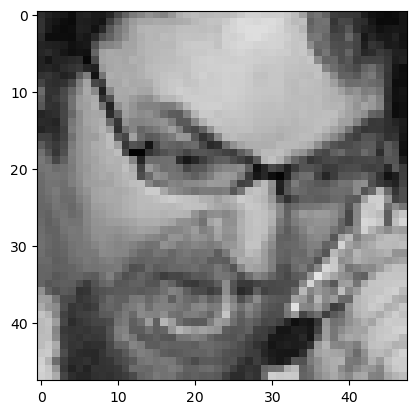

In [28]:
for category in classes:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

In [104]:
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join(data_dir, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_resized = preprocess_image(img_arr)
                img_gray = convert_to_grayscale(img_resized)
                img_normalized = normalize_image(img_gray)
                training_data.append([img_normalized, class_num])
            except Exception as e:
                pass

In [105]:
create_training_data()

In [106]:
print(len(training_data))

32880


In [113]:
X = []
Y = []
for features, label in training_data:
    X.append(features)
    Y.append(label)
    
X = np.array(X)

In [114]:
X.shape

(32880, 48, 48)

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [116]:
Y_train = to_categorical(Y_train, num_classes=num_labels)
Y_test = to_categorical(Y_test, num_classes=num_labels)

In [117]:
Y_train.shape

(26304, 7)

In [118]:
X_test.shape

(6576, 48, 48)

In [119]:
X_train = X_train.reshape(-1, 48,48,1)
X_train.shape

(26304, 48, 48, 1)

In [120]:
X_test = X_test.reshape(-1, 48,48,1)
X_test.shape

(6576, 48, 48, 1)

In [123]:
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
model.compile(loss='categorical_crossentropy'
                , optimizer=keras.optimizers.Adam()
                , metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=batch_size,
    epochs=25
)

Epoch 1/25


C:\Users\Bojana\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 545ms/step - accuracy: 0.2194 - loss: 2.0571
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.3700 - loss: 1.6120
Epoch 3/25


C:\Users\Bojana\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


128/128 ━━━━━━━━━━━━━━━━━━━━ 64s 499ms/step - accuracy: 0.4054 - loss: 1.5154
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.4525 - loss: 1.4281
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 70s 549ms/step - accuracy: 0.4750 - loss: 1.3706
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.4948 - loss: 1.3272
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 61s 472ms/step - accuracy: 0.5110 - loss: 1.2733
Epoch 8/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 38s 295ms/step - accuracy: 0.5326 - loss: 1.2236
Epoch 9/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 62s 486ms/step - accuracy: 0.5406 - loss: 1.2018
Epoch 10/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 39s 305ms/step - accuracy: 0.5597 - loss: 1.1497
Epoch 11/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 70s 544ms/step - accuracy: 0.5728 - loss: 1.1249
Epoch 12/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.5893 - loss: 1.0816
Epoch 13/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 535ms/step - accuracy: 0.5890 - loss: 1.0809
Epoch 14/25
128/128 ━━━━━━━━

In [126]:
y_pred = model.predict(X_test)

206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step


In [127]:
from sklearn.metrics import accuracy_score
ac=accuracy_score(Y_test.round(), y_pred.round())
print('accuracy of the model: ',ac)

accuracy of the model:  0.4530109489051095


In [128]:
model.save("EmotionDetectionImageModel.keras")